# **Understand and Inspect the Dataset for Fat Tails**

### Visual analysis

date_id              0
time_id              0
symbol_id            0
weight               0
feature_00     1944210
                ...   
responder_4          0
responder_5          0
responder_6          0
responder_7          0
responder_8          0
Length: 92, dtype: int64


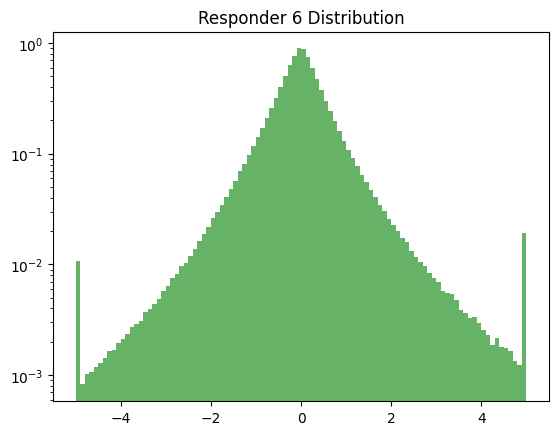

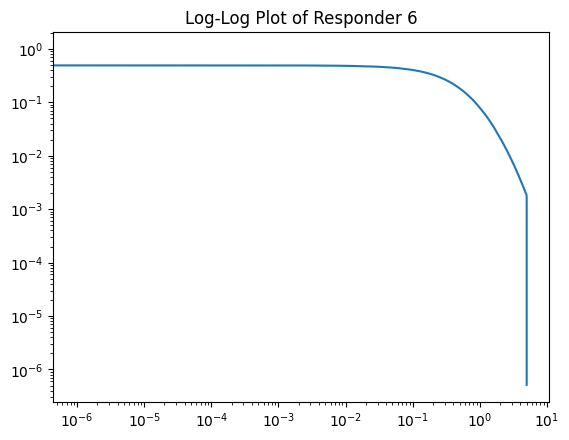

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/JaneStreetKaggleCompetition/data/raw/train.parquet/partition_id=0/part-0.parquet')

# Check for missing values
print(df.isnull().sum())

responder = df['responder_6']
plt.hist(responder, bins=100, density=True, alpha=0.6, color='g')
plt.title('Responder 6 Distribution')
plt.yscale('log')  # Log scale to inspect fat tails
plt.show()

# Log-log plot for tail
sorted_responder = np.sort(responder)
plt.loglog(sorted_responder, np.arange(len(sorted_responder), 0, -1) / len(sorted_responder))
plt.title('Log-Log Plot of Responder 6')
plt.show()


**Responder 6 Distribution (Linear Plot):**

  Responder 6 is approximatly symmetric aroung 0.

  The distribution is not normal (Gaussian). Its sharp peak and long tails are indicative of fat tails, a common characteristic in financial data.

**Log-Log Plot:**

  The straight part in the middle suggests that the tail behavior might follow a power law, which aligns with your calculation of the tail index (α = 2.26)
  
  Fat-tailed distributions indicate that extreme events (large positive or negative values) occur more often than they would in a Gaussian distribution.

### Statistical

In [8]:
from scipy.stats import kurtosis

# Kurtosis for responder_6
kurt = kurtosis(responder, fisher=True)
print(f'Kurtosis of Responder 6: {kurt}')

# Hill estimator
def hill_estimator(data, threshold_percentile=95):
    threshold = np.percentile(data, threshold_percentile)
    tail_data = data[data > threshold]
    alpha = len(tail_data) / np.sum(np.log(tail_data / threshold))
    return alpha

alpha = hill_estimator(responder)
print(f'Tail index (alpha): {alpha}')


Kurtosis of Responder 6: 6.820833450753845
Tail index (alpha): 2.2578235814034424


**Interpreting Statistical Indicators**

Kurtosis=6.82 (greater than 3): This indicates the presence of **leptokurtic behavior**, meaning the distribution has heavier tails and a sharper peak than a normal distribution. This aligns with the visual evidence of fat tails.

α=2.26: A tail index between 2 and 3 suggests that the distribution has finite variance (but potentially infinite higher moments, such as skewness). This further confirms the fat-tailed nature of the data.

Tail index estimation is critical for understanding the risk of extreme values in financial markets.


In [9]:
# Calculate statistics
print("Mean:", df['responder_6'].mean())
print("Variance:", df['responder_6'].var())
print("Skewness:", df['responder_6'].skew())
print("Kurtosis:", kurtosis(df['responder_6']))

Mean: 0.0014876343
Variance: 0.7563174366950989
Skewness: 0.29999408
Kurtosis: 6.820833450753845


In [ ]:
# %cd drive/MyDrive/Colab \Notebooks/JaneStreetKaggleCompetition
# %pwd
# !git status
# !git init
# !git status
# !git rm --cached data/raw
!cat .gitignore
# !echo "data/raw" >> .gitignore


data/raw


In [19]:
# %cd /content/drive/MyDrive/Colab\ Notebooks/JaneStreetKaggleCompetition
!python src/preprocess.py


Dropping 18 columns
Imputing missing values in feature_08
/content/drive/MyDrive/Colab Notebooks/JaneStreetKaggleCompetition/src/preprocess.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
Imputing missing values in feature_15
Imputing missing values in feature_16
Imputing missing values in feature_17
Imputing missing values in feature_18
Imputing missing values in feature_19
Imputing missing values in feature_32
Imputing missing values in feature_33
Imputing missing values in

In [20]:
# Load data
dataframe = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/JaneStreetKaggleCompetition/data/processed/train_processed.parquet')

dataframe.head()


,date_id,time_id_x,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,...,time_id_y,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
0,0,0,1,3.889038,0.851033,0.242971,0.263400,-0.891687,11,7,...,0.0,-0.651829,-1.707840,-0.893942,-1.065488,-1.871338,-0.615652,-1.162801,-1.205924,-1.245934
1,0,0,7,1.370613,0.676961,0.151984,0.192465,-0.521729,11,7,...,0.0,-0.114118,-0.198511,-0.200027,-0.410021,-0.135167,-0.182887,-0.492168,-0.142915,-0.202081
2,0,0,9,2.285698,1.056285,0.187227,0.249901,-0.773050,11,7,...,0.0,-0.529529,0.040104,-0.333090,-0.959040,-1.318411,-0.774299,-0.716492,-1.471419,-1.107083
3,0,0,10,0.690606,1.139366,0.273328,0.306549,-1.262223,42,5,...,0.0,-0.709064,-0.137431,-0.475960,-0.506644,-0.297788,-0.530738,-0.263427,-0.169489,-0.410877
4,0,0,14,0.440570,0.955200,0.262404,0.344457,-0.613813,44,3,...,0.0,0.464961,0.077041,0.601805,-0.178444,1.127965,-0.445524,-0.507432,0.985169,-1.497043
